Estamos ante el caso de una empresa que está abriendo 2 nuevas oficinas. En la primera, en Saveedra, cuenta con 5 espacios y en la segunda, en Pilar, cuenta con 8 espacios. La empresa debe asignar cada uno de los 13 espacios a las distintas áreas de trabajo (marketing, contabilidad, data, ventas, rrhh, finanzas, operaciones, etc).

Decide asignar los espacios teniendo en cuenta dos factores principales:
- La distancia entre los espacios
- El flow de personas que se mueven y comunican de un área a la otra durante el día.

El objetivo es minimizar la distancia total recorrida por los empleados de la empresa para garantizar una mayor **productividad**.

Para tomar esa decisión utilizaremos un algoritmo genético. Este es un problema de optimización.

In [12]:
import random
import matplotlib.pyplot as plt
import numpy as np

#### Oficina con 5 espacios:

In [42]:
# Setup del problema
num_facilities = 5 #número de áreas dentro de una empresa

# El flow es el # de veces que cada área interactua con la otra en el día
# Por ejemplo el área 2 interactua 5 veces con el área 1, 3 veces con el área 3, 0 veces con el área 4 y 2 veces con el área 1
flow = np.array([
    [0, 5, 2, 4, 1], #área 1
    [5, 0, 3, 0, 2], #área 2
    [2, 3, 0, 7, 5],
    [4, 0, 7, 0, 3],
    [1, 2, 5, 3, 0]
])

#Distancia entre los espacios
#Por ejemplo el espacio 2 está a 2 unidades del espacio 1, a 4 unidades del espacio 3, a 2 unidades del espacio 4 y a 3 unidades del espacio 5.
distance = np.array([
    [0, 2, 3, 1, 4], #espacio 1
    [2, 0, 4, 2, 3], #espacio 2
    [3, 4, 0, 5, 1],
    [1, 2, 5, 0, 2],
    [4, 3, 1, 2, 0]
])

Lo más importante es definir el genoma y la función de aptitud correctos.

In [43]:
# Áreas Espacio 1: [Marketing, Ventas, RRHH, Finanzas y Contabilidad]
# Donde Marketing es 0, Ventas 1, RRHH 2, Finanzas 3 y Contabilidad 4
areas = [0, 1, 2, 3, 4]

#El genoma será la asignación de estas 5 áreas a un espacio

def create_individual():
    random.shuffle(areas) #Asignamos los espacios de manera random
    return areas

# La función de aptitud tendrá en cuenta la distancia y flow para calcular la distancia total de determinada asignación de espacios
# #Buscamos minimizar la distancia total
def fitness(individual):
    total_distance = 0
    for i in range(len(areas)):
        for j in range(len(areas)):
            #Esta es nuestra fórmula de fitness. Es la distancia entre dos áreas ponderado por el flow entre ellas
            total_distance += flow[i][j] * distance[individual[i]][individual[j]]

    return total_distance

Las otras funciones que usaremos:

In [44]:
def create_population():
    # Creamos a la población inicial de genomas
    return [create_individual() for _ in range(population_size)]

def select_parent(population, fitness_values):
    # Selección Accept-Reject
    max_fitness = max(fitness_values)  # Buscamos el individuo con fitness más alto
    while True:
        #Elegimos un valor random entre 0 y el tamaño de la población -1 y lo usamos como candidato
        index = random.randint(0, len(population) - 1)
        candidate = population[index]

        #Calculamos el fitness del candidato
        candidate_fitness = fitness_values[index]

        #Transformamos el fitness para que mayor fitness sea positivo
        fitness_transformed = max_fitness - candidate_fitness #Mientras más chico candidate_fitness, más grande el nro

        # Normalizamos el fitness transformado
        candidate_fitness = fitness_transformed / max_fitness

        #Si mi valor random entre 0 y 1 es mayor al fitness normalizado del candidato, rechazo al candidato y vuelve el loop.
        #Sólo quiero a aquellos candidatos con mayor fitness
        if random.uniform(0, 1) <= candidate_fitness:
            return candidate

def crossover(parent1, parent2):
    # Usamos el single-point crossover
    #Definimos el singlepoint de forma random entre 1 y len(areas)-1
    singlePoint = random.randint(1, len(areas) - 1)
    #En base a ese single_point hacemos el crossover entre padres y creamos dos hijos
    child1 = parent1[:singlePoint] + [gene for gene in parent2 if gene not in parent1[:singlePoint]]
    child2 = parent2[:singlePoint] + [gene for gene in parent1 if gene not in parent2[:singlePoint]]

    return (child1, child2)

def mutate(individual):
    # Mutamos un individuo cambiando dos areas de lugar
    if random.random() < mutation_rate:
        i, j = random.sample(range(num_facilities), 2)
        individual[i], individual[j] = individual[j], individual[i]

**Armado del loop del Algoritmo Genético:**

En este caso, como no sabemos cuál es la distancia mínima a la que queremos llegar, lo que definimos es el número de generaciones que tendrá nuestro algoritmo genético.

In [45]:
population_size = 100
num_generations = 2000
mutation_rate = 0.1

# Main GA loop
population = create_population()
best_fitness_values = []
best_individuals = []

for generation in range(num_generations):
    # Evaluate fitness and find the maximum fitness for normalization
    fitness_values = [fitness(area) for area in population]
    best_fitness = min(fitness_values)
    best_individual = population[fitness_values.index(best_fitness)]

    best_fitness_values.append(best_fitness)
    best_individuals.append(best_individual)

    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parent(population, fitness_values)
        parent2 = select_parent(population, fitness_values)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    population = new_population
    print(f"Generation {generation}: Best fitness = {best_fitness}, Best distribution = {best_individual}")

# Output the best solution
best_individual = best_individuals[best_fitness_values.index(min(best_fitness_values))]
print("Best solution:", best_individual)
print("Best fitness:", min(best_fitness_values))

KeyboardInterrupt: 

Se queda en la selección de padres ya que los fitness iniciales son muy grandes y no se logra cumplir la condición. En estos casos, algo como el método del dardo será más útil:

In [46]:
def select_parent(population, fitness_values):
    # Método del dardo (Roulette Wheel Selection)
    max_fitness = max(fitness_values)  # Buscamos el fitness más alto

    # Transformamos los fitness: mejor (menor) fitness ➔ mayor valor transformado
    fitness_transformed = [max_fitness - f for f in fitness_values]

    # Sumamos los fitness transformados
    total_transformed = sum(fitness_transformed)

    # Si todos los individuos tienen el mismo fitness, elegimos uno al azar
    if total_transformed == 0:
        return random.choice(population)

    # Normalizamos para convertir a probabilidades
    probabilities = [f / total_transformed for f in fitness_transformed]

    # Tiramos el dardo
    pick = random.uniform(0, 1)
    current = 0

    # Recorremos sumando las probabilidades
    for individual, probability in zip(population, probabilities):
        current += probability
        if current > pick:
            return individual

    # Por seguridad (nunca debería pasar salvo redondeos extremos)
    return population[-1]

In [47]:
population_size = 5
num_generations = 10000
mutation_rate = 0.2

# Main GA loop
population = create_population()
best_fitness_values = []
best_individuals = []

for generation in range(num_generations):
    # Evaluate fitness and find the maximum fitness for normalization
    fitness_values = [fitness(area) for area in population]
    best_fitness = min(fitness_values)
    best_individual = population[fitness_values.index(best_fitness)]

    best_fitness_values.append(best_fitness)
    best_individuals.append(best_individual)

    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parent(population, fitness_values)
        parent2 = select_parent(population, fitness_values)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    population = new_population
    print(f"Generation {generation}: Best fitness = {best_fitness}, Best distribution = {best_individual}")

# Output the best solution
best_individual = best_individuals[best_fitness_values.index(min(best_fitness_values))]
print("Best solution:", best_individual)
print("Best fitness:", min(best_fitness_values))

Streaming output truncated to the last 5000 lines.
Generation 5002: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5003: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5004: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5005: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5006: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5007: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5008: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5009: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5010: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5011: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5012: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5013: Best fitness = 142, Best distribution = [0, 3, 4, 2, 1]
Generation 5014: Best fitness = 156, Best distribution = [1, 3, 4, 2, 0]


Y ploteamos como varía la distancia entre generación y generación:

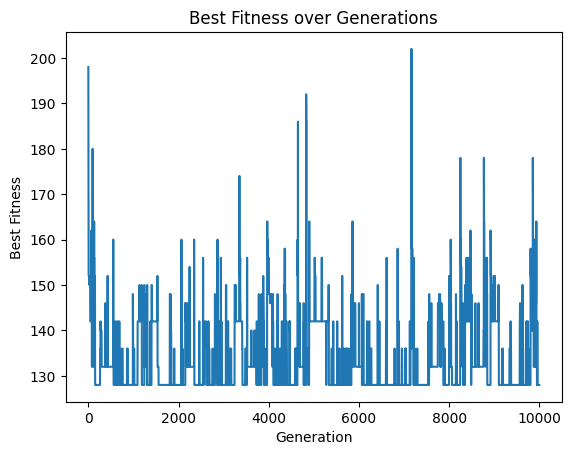

In [48]:
# Mejor Fitness en cada generación
plt.plot(best_fitness_values)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()

#### Oficina con 8 espacios:

In [49]:
# Setup del problema
num_facilities = 8

flow = [
    [0, 2, 0, 1, 3, 4, 2, 1],
    [2, 0, 2, 1, 0, 3, 1, 2],
    [0, 2, 0, 3, 1, 4, 2, 0],
    [1, 1, 3, 0, 2, 1, 3, 2],
    [3, 0, 1, 2, 0, 2, 1, 4],
    [4, 3, 4, 1, 2, 0, 1, 3],
    [2, 1, 2, 3, 1, 1, 0, 2],
    [1, 2, 0, 2, 4, 3, 2, 0]
]
distance = [
    [0, 1, 2, 3, 4, 5, 6, 7],
    [1, 0, 1, 2, 3, 4, 5, 6],
    [2, 1, 0, 1, 2, 3, 4, 5],
    [3, 2, 1, 0, 1, 2, 3, 4],
    [4, 3, 2, 1, 0, 1, 2, 3],
    [5, 4, 3, 2, 1, 0, 1, 2],
    [6, 5, 4, 3, 2, 1, 0, 1],
    [7, 6, 5, 4, 3, 2, 1, 0]
]

In [50]:
def create_individual():
    #Creamos un individuo random que será un orden random de designación de espacios
    individual = list(range(num_facilities))
    random.shuffle(individual)
    return individual

def create_population():
    #Creamos la población incicial
    return [create_individual() for _ in range(population_size)]

def fitness(individual):
    #Calculamos el fitness de cada individuo
    total_distance = 0
    for i in range(num_facilities):
        for j in range(num_facilities):
            total_distance += flow[i][j] * distance[individual[i]][individual[j]]
    return total_distance

def select_parent(population, fitness_values):
    # Método del dardo (Roulette Wheel Selection)
    max_fitness = max(fitness_values)  # Buscamos el fitness más alto

    # Transformamos los fitness: mejor (menor) fitness ➔ mayor valor transformado
    fitness_transformed = [max_fitness - f for f in fitness_values]

    # Sumamos los fitness transformados
    total_transformed = sum(fitness_transformed)

    # Si todos los individuos tienen el mismo fitness, elegimos uno al azar
    if total_transformed == 0:
        return random.choice(population)

    # Normalizamos para convertir a probabilidades
    probabilities = [f / total_transformed for f in fitness_transformed]

    # Tiramos el dardo
    pick = random.uniform(0, 1)
    current = 0

    # Recorremos sumando las probabilidades
    for individual, probability in zip(population, probabilities):
        current += probability
        if current > pick:
            return individual

    # Por seguridad (nunca debería pasar salvo redondeos extremos)
    return population[-1]

def crossover(parent1, parent2):
    # Usamos el single-point crossover
    singlePoint = random.randint(1, len(areas) - 1)
    child1 = parent1[:singlePoint] + [gene for gene in parent2 if gene not in parent1[:singlePoint]]
    child2 = parent2[:singlePoint] + [gene for gene in parent1 if gene not in parent2[:singlePoint]]

    return (child1, child2)

def mutate(individual):
    #Mutación
    if random.random() < mutation_rate:
        i, j = random.sample(range(num_facilities), 2)
        individual[i], individual[j] = individual[j], individual[i]

In [53]:
population_size = 100
num_generations = 10000
mutation_rate = 0.1

# Loop del Algoritmo Genético
population = create_population()
best_fitness_values = []
best_individuals = []

for generation in range(num_generations):
    # Evaluamos la fitness y encontramos el máximo
    fitness_values = [fitness(ind) for ind in population]
    best_fitness = min(fitness_values)
    best_individual = population[fitness_values.index(best_fitness)]

    best_fitness_values.append(best_fitness)
    best_individuals.append(best_individual)

    new_population = []
    for _ in range(population_size // 2):
        parent1 = select_parent(population, fitness_values)
        parent2 = select_parent(population, fitness_values)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    population = new_population
    print(f"Generation {generation}: Best fitness = {best_fitness}, Best distribution = {best_individual}")

# Imprimimos la mejor solución
best_individual = best_individuals[best_fitness_values.index(min(best_fitness_values))]
print("Best solution:", best_individual)
print("Best fitness:", min(best_fitness_values))

Streaming output truncated to the last 5000 lines.
Generation 5002: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5003: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5004: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5005: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5006: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5007: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5008: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5009: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5010: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5011: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5012: Best fitness = 264, Best distribution = [5, 3, 0, 1, 7, 4, 2, 6]
Generation 5013: Best fitness = 264, Best distr

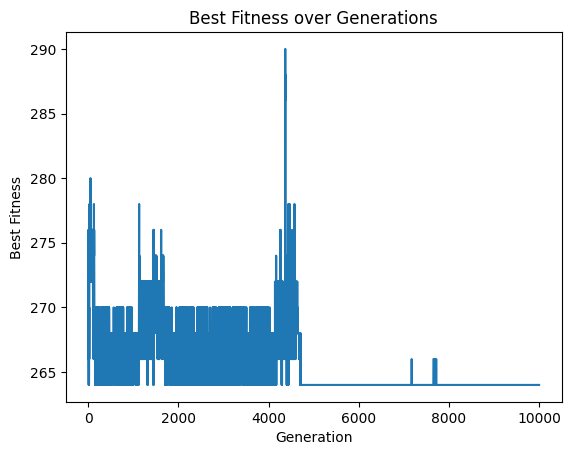

In [54]:
#Fitness de las mejores generaciones
plt.plot(best_fitness_values)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness over Generations')
plt.show()